# Regression via simulation; variable selection; regularization

Linear regression is a basic but important tool. In this notebook we'll look at it from a simulation point of view.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.linear_model import LinearRegression

# regularization methods
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

Here are a couple of simulation functions: what do they do?

In [2]:
# some helper functions we will need for making the data
def make_independent_data(dimension=3, n=1000):
    '''
    Makes independent data in "dimension" dimensions
    '''
    covar = np.diag([1 for i in range(dimension)])
    dat_i = np.random.multivariate_normal([0 for i in range(dimension)], 
                                          covar, n)
    
    return dat_i, covar

def make_correlated_data(dimension, n=1000):
    '''
    Makes dependent data in "dimension" dimensions
    '''
    
    covar = np.zeros((dimension, dimension))
    covar_vec = np.linspace(1,0,dimension)
    for ii in range(dimension):
        for jj in range(dimension):
            covar[ii, jj] = covar_vec[np.abs(ii-jj)]
        dat = np.random.multivariate_normal([0 for i in range(dimension)], covar, n)
    return dat, covar


x, covar = make_correlated_data(5, n=10)

print("\ncovariance matrix: ")
print(covar)


covariance matrix: 
[[1.   0.75 0.5  0.25 0.  ]
 [0.75 1.   0.75 0.5  0.25]
 [0.5  0.75 1.   0.75 0.5 ]
 [0.25 0.5  0.75 1.   0.75]
 [0.   0.25 0.5  0.75 1.  ]]


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: covariance is not symmetric positive-semidefinite.


What is the difference between the two? I've added some correlation between the adjacent indices of variables in the second one, let's see what things look like with some plots.

Try this with the correlated data, what do you see?

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Text(0.5, 0.98, 'Heatmap of Covariance Matrix')

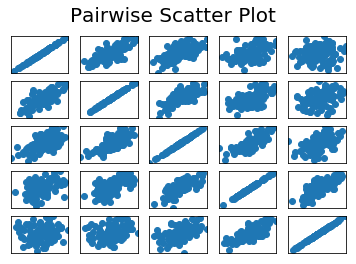

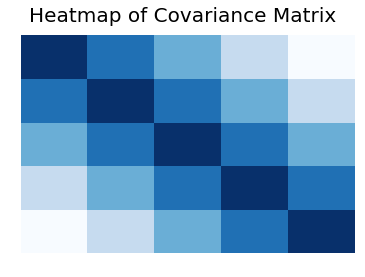

In [3]:
n_data_points = 100
n_features = 5

#X, covar = make_independent_data(n_features, n_data_points)
X, covar = make_correlated_data(n_features, n_data_points)

fig = plt.figure()

covar_plot = np.zeros((n_features,n_features))
count = 0
for ii in range(n_features):
    for jj in range(n_features):
        ax = plt.subplot(n_features, n_features, count + 1)
        plt.setp(ax, xticks=(), yticks=())    
        plt.scatter(X[:, ii], X[:, jj])  
        ax.set_xlim([np.min(X), np.max(X)])
        ax.set_ylim([np.min(X), np.max(X)])
        count += 1
        
        covar_plot[ii,jj] = covar[n_features-1-ii,jj]
        
fig.suptitle('Pairwise Scatter Plot', fontsize=20)
        
        
fig = plt.figure()
heatmap = plt.pcolor(covar_plot, cmap=mp.cm.Blues)
plt.axis('off')
fig.suptitle('Heatmap of Covariance Matrix', fontsize=20)

In [4]:
def create_data_set(n_data_points, 
                    n_features, 
                    n_noise_features, 
                    signal_strength, 
                    n_train_points):
    """Create a complete data set for a regression problem

    Arguments:
    n_data_points: integer number of data points
    n_features: integer number of features that have nonzero coefficients
    n_noise_features: integer number of features that have zero coefficients
    signal_strength: mean value of nonzero coefficients
    n_train_points: number of data points to place in training set from the total n_data_points
    
    Y = a1*x1 + a2*x2 + a3*x3 + ... + a(n_feature)x(n_feature) + 0*xn1 + 0*xn2 + .. + 
    """
    
    # create true set of coefficients
    true_linear_model = np.concatenate((np.random.normal(size=n_features, scale=0.5) + signal_strength, 
                                        np.zeros(n_noise_features)))

    # make things the right shape
    true_linear_model = np.reshape(np.array(true_linear_model), 
                                   newshape=(n_features + n_noise_features, 1))

    # make the data now using make_correlated_data
    X, _ = make_correlated_data(n_features + n_noise_features, n_data_points)

    # use the features and the coefficients to make the data
    Y_signal = np.dot(X, true_linear_model)
    Y_noise = np.reshape(np.random.normal(size=n_data_points), newshape=(n_data_points, 1))
    Y = np.add(Y_signal, Y_noise)

    # make Y the right shape
    Y = Y.flatten()

    # train, test split
    train_data, train_labels = X[:n_train_points], Y[:n_train_points]
    test_data, test_labels = X[n_train_points:], Y[n_train_points:]
    
    return train_data, train_labels, test_data, test_labels, true_linear_model

Now, let's run some simulations: what variables does linear regression pick up?

Is this a harder problem with correlated data?

What are some ways we can reduce estimation error?

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Linear model test MSE:  0.9465659844830865
Estimation error for parameters:  0.5451538882685077


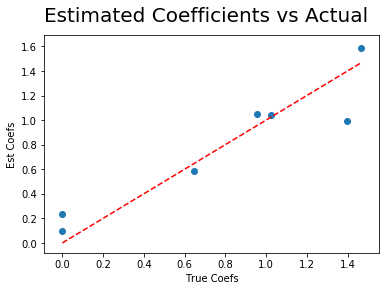

In [5]:
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(500, 5, 2, 1, 350)

lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_coef = lm.coef_

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE: ", lm_test_mse)

# plot estimated coefficients versus the actual coefficients
fig = plt.figure()
plt.plot([min(true_linear_model),max(true_linear_model)],[min(true_linear_model),max(true_linear_model)],'r--')
plt.scatter(true_linear_model, lm_coef)
fig.suptitle('Estimated Coefficients vs Actual', fontsize=20)
plt.xlabel('True Coefs')
plt.ylabel('Est Coefs') 

# these are the indices of nonzero entries of the coefficient vector
# print 'index of nonzero linear regression variables: \n', np.where(lm_coef != 0)

# what is wrong with this measure?
estimation_error = ((true_linear_model - lm_coef) ** 2).mean()

print("Estimation error for parameters: ", estimation_error)

One thing that is going wrong here: we are assigning non-zero vlaues to coefficients with truly zero coefficients.

Now, we can try implementing stepwise regression, which is a simple greedy algorithm for selecting a sub model. Here's a plan:

1. Start with an empty model (no variables used)
2. For each feature not included:
a. Fit a model with that feature included, record the prediction performance
3. Add the feature that did the best in 2a to the set
4. Repeat until all features are in the model

How could we choose how to stop?

How can we see if it is reasonable to stop?

round 0
Variables included:  [2] 

round 1
Variables included:  [2, 4] 

round 2
Variables included:  [2, 4, 1] 

round 3
Variables included:  [2, 4, 1, 3] 

round 4
Variables included:  [2, 4, 1, 3, 0] 

round 5
Variables included:  [2, 4, 1, 3, 0, 6] 

round 6
Variables included:  [2, 4, 1, 3, 0, 6, 7] 

round 7
Variables included:  [2, 4, 1, 3, 0, 6, 7, 5] 

Sequence of test set errors:
 [22.366018362808724, 3.4932945322134037, 1.5785510465239905, 1.19817260488897, 1.1676423265096867, 1.167191088579618, 1.2273756666896325, 1.2355361007424268, 1.3555764836745188] 

Differences btw steps:
 [-1.88727238e+01 -1.91474349e+00 -3.80378442e-01 -3.05302784e-02
 -4.51237930e-04  6.01845781e-02  8.16043405e-03  1.20040383e-01] 

Final set of variables:
 [2, 4, 1, 3, 0] 

Selected coefficients; true values:
 [1.5765179  1.49066039 1.1713402  0.87378198 0.12511726] 

Selected coefficients; estimated values:
 [1.63350841 0.23145639 1.60851812 0.14051906 1.29512699] 

Not selected coefficients; tr

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Text(0, 0.5, 'Test Set Error')

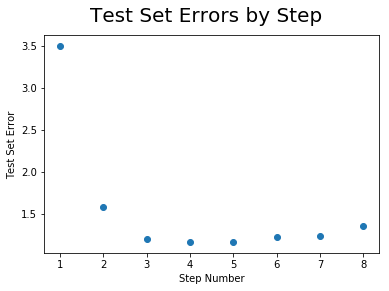

In [6]:
np.random.seed(100) # "simulation"

## If the number of data points are larger, the not selected coefficients are the 0 "noice_features"
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(1000, 5, 3, 1, 60)

invar = []
outvar = list(range(train_data.shape[1]))

# begin with the null model
intercept = train_labels.mean()
error = ((test_labels - intercept) ** 2).mean()

errorseq = [error]

##################
# implement the algorithm here

for jj in range(train_data.shape[1]):
    varscores = []
    print('round ' + str(jj))
    for idx, ovar in enumerate(outvar):
        invar_temp = list(invar)
        invar_temp.append(ovar)
        
        ## YOUR CODE HERE: select best feature
        
        lm = LinearRegression()
        lm.fit(train_data[:,invar_temp], train_labels)
        lm_test_preds = lm.predict(test_data[:, invar_temp])
        score = ((lm_test_preds - test_labels)**2).mean()
        varscores.append(score)
        
        
       
        
    min_score = np.argmin(np.array(varscores))
    errorseq.append(varscores[min_score]) # store the score of the best variable
    invar.append(outvar[min_score]) # choose the best variable in this step
    outvar.pop(min_score)
    print('Variables included: ', invar, '\n')

###################    

# the final decisions
adj_differences = np.array(errorseq[1:]) - np.array(errorseq[:-1])
cut_process = (np.where(adj_differences > 0)[0][0])

# results; diagnostics
print("Sequence of test set errors:\n", errorseq, '\n')
print("Differences btw steps:\n", adj_differences, '\n')
print("Final set of variables:\n", invar[:cut_process], '\n')
print("Selected coefficients; true values:\n", true_linear_model[invar[:cut_process]][:,0], '\n')
print('Selected coefficients; estimated values:\n', lm.coef_[invar[:cut_process]], '\n')
print('Not selected coefficients; true values:\n', true_linear_model[invar[cut_process:]][:,0], '\n')
print('Not selected coefficients; estimated values:\n', lm.coef_[invar[cut_process:]], '\n')
fig = plt.figure()
plt.scatter(range(len(errorseq))[1:], errorseq[1:])
fig.suptitle('Test Set Errors by Step', fontsize=20)
plt.xlabel('Step Number')
plt.ylabel('Test Set Error') 

Is this the only way to do variable selection? Turns out there is a way to cast this entire task as a single optimization problem, called *regularization*.

**Regularization in general**

Typical learning objectives or cost functions simply optimize the fit. It looks like (here beta are some parameters that define the model, say the coefficients in linear regression):

$Cost(\beta) = fit(\beta)$

And we do:

$\hat\beta = argmin(Cost(\beta))$

So, we choose the beta that minimizes the cost, that is, provides the best fit to the training data.

Regularization simply tweaks this by:

$RegularizedCost(\beta) = fit(\beta) + \alpha * penalty(\beta)$

And, as above:

$regularized\ \hat\beta = argmin(RegularizedCost(\beta))$

So, what is the penalty? It is a way to define the complexity of $\beta$. We'll see how complexity is defined below. But, in general, as the fit gets better, the complexity becomes higher, and so the objective nicely formalizes this tradeoff. $\alpha$ is a constant (we'll have to pick it) that defines the strength of this tradeoff.

We can define complexity in a couple of ways: (1) large values of coefficients are one indication; (2) using many dimensions (non-zero coefficients) are another indication. Regularization can caputre both.

## L2 regularization: shrinkage

Let's explore the first type of regularization, L2 regularization. It takes the form:

$Cost(\beta) = fit(\beta) + \alpha * \sum_j\beta_j^2$

Some useful docs for the following:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


In [7]:
lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

rm = Ridge(alpha=5, normalize=False)
rm.fit(train_data, train_labels)

rm_test_mse = ((rm.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE:     ", lm_test_mse)
print("Ridge regression test MSE: ", rm_test_mse)
print("Linear regression does worse on the test set: ", lm_test_mse > rm_test_mse)

# how can we choose a the best paramater?
print(lm.coef_)
rm.coef_

Linear model test MSE:      1.3555764836745205
Ridge regression test MSE:  1.2883192117654494
Linear regression does worse on the test set:  True
[ 0.23145639  1.63350841  1.29512699  0.14051906  1.60851812  0.72226505
 -0.34195481  0.37041938]


array([ 0.42424738,  1.32306234,  1.15353771,  0.60463473,  1.17668208,
        0.66365258, -0.07286625,  0.27990081])

Now, let's see what happens to the coefficients as alpha changes. Here's an investigation for a single coefficient. What happens to other coefficients? How is this reducing complexity? You can also try out making a *regularization path plot*, see:

http://fa.bianp.net/blog/2011/ridge-regression-path/

Alpha is 0.0001
1.3552808001195324
Alpha is 0.001
1.3526822977289834
Alpha is 0.01
1.3319569519398822
Alpha is 0.1
1.3109755805965917
Alpha is 1
2.084107046410402
Alpha is 10
10.836158781648347
Alpha is 100
20.435138522729734
Alpha is 1000
22.159853856130823


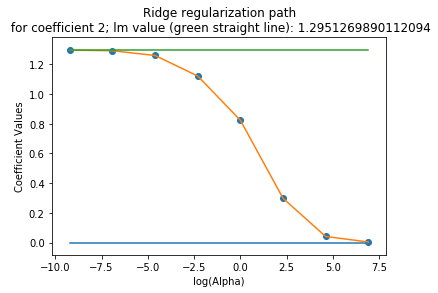

[1.29470429 1.29096409 1.25889202 1.12076091 0.82298772 0.29827618
 0.04155777 0.0043287 ]


In [8]:
alpha_vec = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
coef_idx = 2
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

lm = LinearRegression()
lm.fit(train_data, train_labels)
lm_coef = lm.coef_[coef_idx]
lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

for aa_idx, aa in enumerate(alpha_vec):
    rm = Ridge(alpha=aa, normalize=True)
    rm.fit(train_data, train_labels)
    rm_coef = rm.coef_[coef_idx]
    
    coef_values[aa_idx] = rm_coef
    lm_coef_line[aa_idx] = lm_coef
    
    rm_test_mse = ((rm.predict(test_data) - test_labels) ** 2).mean()
    print("Alpha is", aa)
    print(rm_test_mse)
    #print "Linear regression does worse on the test set: ", lm_test_mse > rm_test_mse
    
plt.plot(np.log(alpha_vec), lm_coef_line * 0)    
plt.plot(np.log(alpha_vec), coef_values)
plt.plot(np.log(alpha_vec), lm_coef_line)
plt.scatter(np.log(alpha_vec), coef_values)
plt.title('Ridge regularization path\n for coefficient ' + str(coef_idx) + 
          '; lm value (green straight line): ' + str(lm_coef))
plt.ylabel('Coefficient Values') 
plt.xlabel('log(Alpha)') 
plt.show()

print(coef_values)

### L1 Regularization: the lasso; shrinkage and selection

Let's explore another type of regularization, L1 regularization. It takes the form:

$Cost(\beta) = fit(\beta) + \alpha * \sum_j|\beta_j|$

Some useful docs for the following:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [9]:
lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

# try playing with the alpha
las = Lasso(alpha=0.1, normalize=False, max_iter=100)
las.fit(train_data, train_labels)

las_test_mse = ((las.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE: ", lm_test_mse)
print("Lasso regression test MSE: ", las_test_mse)

print("Linear regression does worse on the test set: ", lm_test_mse > las_test_mse)

print(lm.coef_)
print(las.coef_)

Linear model test MSE:  1.3555764836745205
Lasso regression test MSE:  1.224151603406559
Linear regression does worse on the test set:  True
[ 0.23145639  1.63350841  1.29512699  0.14051906  1.60851812  0.72226505
 -0.34195481  0.37041938]
[0.05867296 1.66392688 1.29261828 0.1850042  1.66454739 0.45916025
 0.         0.05681538]


Alpha is  1e-05
1.3553363911066447
Linear regression does worse on the test set:  True
Alpha is  0.0001
1.353189894555246
Linear regression does worse on the test set:  True
Alpha is  0.001
1.334325254752861
Linear regression does worse on the test set:  True
Alpha is  0.01
1.2603581205158958
Linear regression does worse on the test set:  True
Alpha is  0.1
1.665185228021567
Linear regression does worse on the test set:  False
Alpha is  1
22.366018362808724
Linear regression does worse on the test set:  False
Alpha is  10
22.366018362808724
Linear regression does worse on the test set:  False
Alpha is  100
22.366018362808724
Linear regression does worse on the test set:  False
[0.72146431 0.71425778 0.64593757 0.49222508 0.         0.
 0.         0.        ]


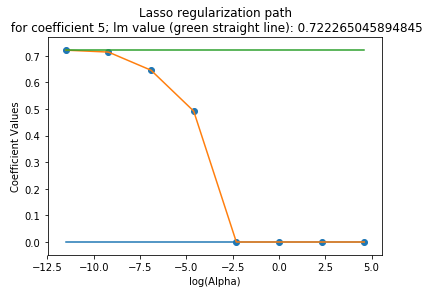

In [10]:
alpha_vec = [0.00001, 0.0001, 0.001, 0.01, 0.1,1, 10, 100]
coef_idx = 5
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

lm = LinearRegression()
lm.fit(train_data, train_labels)
lm_coef = lm.coef_[coef_idx]
lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

for aa_idx, aa in enumerate(alpha_vec):

    las = Lasso(alpha=aa, normalize=True, max_iter=1000)
    las.fit(train_data, train_labels)
    las_coef = las.coef_[coef_idx]
 
    coef_values[aa_idx] = las_coef
    lm_coef_line[aa_idx] = lm_coef

    las_test_mse = ((las.predict(test_data) - test_labels) ** 2).mean()
    print("Alpha is ", aa)
    print(las_test_mse)
    print("Linear regression does worse on the test set: ", lm_test_mse > las_test_mse)
    
print(coef_values) 

plt.plot(np.log(alpha_vec), lm_coef_line * 0)
plt.plot(np.log(alpha_vec), coef_values)
plt.plot(np.log(alpha_vec), lm_coef_line)
plt.scatter(np.log(alpha_vec), coef_values)
plt.title('Lasso regularization path\n for coefficient ' + str(coef_idx) + 
          '; lm value (green straight line): ' + str(lm_coef))
plt.ylabel('Coefficient Values') 
plt.xlabel('log(Alpha)') 
plt.show()